In [2]:
import numpy as np
import pandas as pd
import torch
from pykalman import KalmanFilter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# بارگیری داده‌ها
df = pd.read_csv("balanced_compressor_time_series_data.csv")

# انتخاب ویژگی‌های کلیدی برای فیلتر کالمن
features = ["Pressure_In", "Temperature_In", "Efficiency", "Vibration", "Power_Consumption"]

# اعمال فیلتر کالمن برای حذف نویز از داده‌ها
def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=data[0], n_dim_obs=1)
    filtered_data, _ = kf.filter(data)
    return filtered_data.flatten()

for feature in features:
    df[f"{feature}_filtered"] = apply_kalman_filter(df[feature].values)

# نرمال‌سازی داده‌ها
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [3]:
from sklearn.cluster import KMeans

# انتخاب ویژگی‌های کلیدی برای خوشه‌بندی
X_features = df[["Pressure_In_filtered", "Temperature_In_filtered", "Efficiency_filtered", "Vibration_filtered", "Power_Consumption_filtered"]]

# اجرای الگوریتم K-Means با 5 خوشه
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster_Label"] = kmeans.fit_predict(X_features)

# تعریف وضعیت‌های کمپرسور بر اساس نتایج خوشه‌بندی
cluster_mapping = {
    0: "Normal",
    1: "Load Surge",
    2: "Temperature Overload",
    3: "Mechanical Imbalance",
    4: "Critical Fault"
}

df["Status"] = df["Cluster_Label"].map(cluster_mapping)

# تبدیل وضعیت‌ها به عدد برای مدل یادگیری عمیق
label_encoder = LabelEncoder()
df["Status"] = label_encoder.fit_transform(df["Status"])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# تبدیل داده‌ها به Tensor
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df["Status"].values, dtype=torch.long)

# تبدیل داده‌ها به فرمت مورد نیاز برای LSTM
sequence_length = 60
X_sequences = []
y_sequences = []

for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length])

X_sequences = torch.stack(X_sequences)
y_sequences = torch.tensor(y_sequences)

# تقسیم داده‌ها به مجموعه‌ی آموزش و آزمایش
train_size = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# تعریف دیتالودر PyTorch
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# تعریف مدل LSTM
class CompressorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CompressorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# مقداردهی اولیه مدل
model = CompressorLSTM(input_size=X.shape[1], hidden_size=64, num_layers=2, num_classes=len(label_encoder.classes_))

# تعریف تابع هزینه و بهینه‌ساز
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# آموزش مدل
num_epochs = 50
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 0.5351
Epoch [2/50], Loss: 0.6470
Epoch [3/50], Loss: 0.3722
Epoch [4/50], Loss: 0.5370
Epoch [5/50], Loss: 0.3996
Epoch [6/50], Loss: 0.4004
Epoch [7/50], Loss: 0.4265
Epoch [8/50], Loss: 0.5393
Epoch [9/50], Loss: 0.2971
Epoch [10/50], Loss: 0.3157
Epoch [11/50], Loss: 0.2892
Epoch [12/50], Loss: 0.5447
Epoch [13/50], Loss: 0.3018
Epoch [14/50], Loss: 0.5203
Epoch [15/50], Loss: 0.5019
Epoch [16/50], Loss: 0.3258
Epoch [17/50], Loss: 0.3458
Epoch [18/50], Loss: 0.3538
Epoch [19/50], Loss: 0.4025
Epoch [20/50], Loss: 0.4173
Epoch [21/50], Loss: 0.4367
Epoch [22/50], Loss: 0.3805
Epoch [23/50], Loss: 0.2720
Epoch [24/50], Loss: 0.2799
Epoch [25/50], Loss: 0.1772
Epoch [26/50], Loss: 0.4409
Epoch [27/50], Loss: 0.4208
Epoch [28/50], Loss: 0.4599
Epoch [29/50], Loss: 0.3918
Epoch [30/50], Loss: 0.8676
Epoch [31/50], Loss: 0.3753
Epoch [32/50], Loss: 0.4549
Epoch [33/50], Loss: 0.2689
Epoch [34/50], Loss: 0.2047
Epoch [35/50], Loss: 0.2203
Epoch [36/50], Loss: 0.1783
E

In [7]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler

# 1️⃣ بارگیری داده‌ها
df = pd.read_csv("balanced_compressor_time_series_data.csv")

# 2️⃣ انتخاب ویژگی‌های کلیدی
features = ["Pressure_In", "Temperature_In", "Efficiency", "Vibration", "Power_Consumption"]

# 3️⃣ تابع اعمال فیلتر کالمن
def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=data[0], n_dim_obs=1)
    filtered_data, _ = kf.filter(data)
    return filtered_data.flatten()

# اعمال فیلتر کالمن روی ویژگی‌های انتخابی
for feature in features:
    df[f"{feature}_filtered"] = apply_kalman_filter(df[feature].values)

# 4️⃣ نرمال‌سازی داده‌ها
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 5️⃣ ذخیره داده‌های پردازش‌شده
df.to_csv("processed_data.csv", index=False)
print("✅ داده‌های پیش‌پردازش‌شده ذخیره شدند!")
print(df.head()) 


✅ داده‌های پیش‌پردازش‌شده ذخیره شدند!
   Time  Pressure_In  Temperature_In  Flow_Rate  Pressure_Out  \
0     0     0.538706        0.836634  12.156184     17.436829   
1     1     0.510866        0.708750  12.010572     17.406759   
2     2     0.573921        0.809507  11.907004     17.954038   
3     3     0.642631        0.739031  11.920992     18.213320   
4     4     0.542789        0.755167  12.045394     17.854835   

   Temperature_Out  Efficiency  Power_Consumption  Vibration     Status  ...  \
0       203.077815    0.411828           0.634569   0.640042  Imbalance  ...   
1       197.494853    0.543649           0.506438   0.496250     Normal  ...   
2       203.341908    0.505381           0.559500   0.433861     Normal  ...   
3       201.438404    0.500011           0.552946   0.566397     Normal  ...   
4       200.631142    0.573516           0.545327   0.554851     Normal  ...   

       Stiffness     Damping   Density   Velocity  Viscosity  \
0  500845.859275  499.2963

Epoch [1/50], Loss: 0.0381
Epoch [2/50], Loss: 0.1199
Epoch [3/50], Loss: 0.1655
Epoch [4/50], Loss: 0.1771
Epoch [5/50], Loss: 0.0888
Epoch [6/50], Loss: 0.2122
Epoch [7/50], Loss: 0.1399
Epoch [8/50], Loss: 0.1140
Epoch [9/50], Loss: 0.0276
Epoch [10/50], Loss: 0.1525
Epoch [11/50], Loss: 0.3600
Epoch [12/50], Loss: 0.0593
Epoch [13/50], Loss: 0.1407
Epoch [14/50], Loss: 0.2153
Epoch [15/50], Loss: 0.2558
Epoch [16/50], Loss: 0.0156
Epoch [17/50], Loss: 0.0676
Epoch [18/50], Loss: 0.0310
Epoch [19/50], Loss: 0.1844
Epoch [20/50], Loss: 0.0199
Epoch [21/50], Loss: 0.1361
Epoch [22/50], Loss: 0.0502
Epoch [23/50], Loss: 0.0038
Epoch [24/50], Loss: 0.1071
Epoch [25/50], Loss: 0.1366
Epoch [26/50], Loss: 0.1446
Epoch [27/50], Loss: 0.0981
Epoch [28/50], Loss: 0.4477
Epoch [29/50], Loss: 0.0727
Epoch [30/50], Loss: 0.0335
Epoch [31/50], Loss: 0.0196
Epoch [32/50], Loss: 0.0631
Epoch [33/50], Loss: 0.3782
Epoch [34/50], Loss: 0.1114
Epoch [35/50], Loss: 0.2148
Epoch [36/50], Loss: 0.1100
E

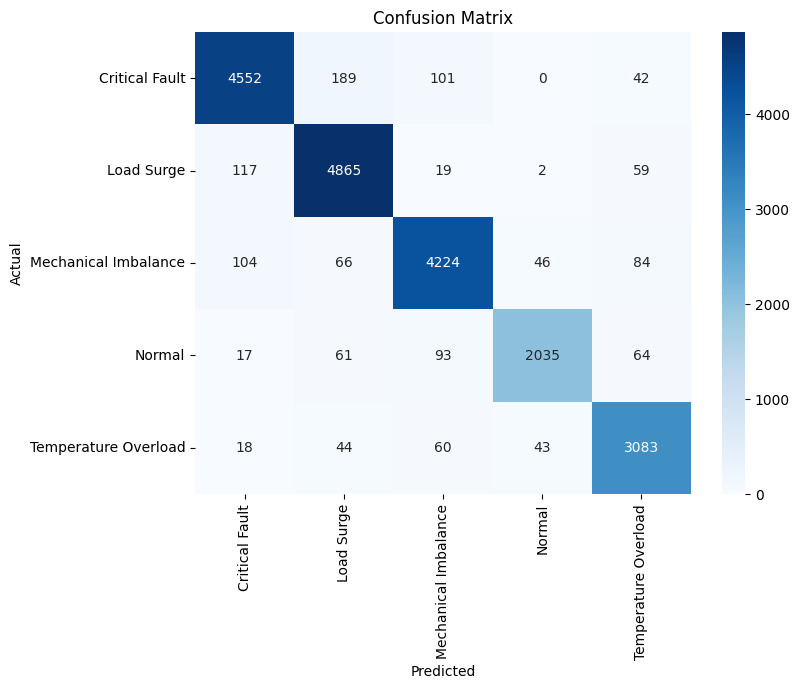

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from pykalman import KalmanFilter
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ بارگیری داده‌ها
df = pd.read_csv("balanced_compressor_time_series_data.csv")

# 2️⃣ انتخاب ویژگی‌های کلیدی
features = ["Pressure_In", "Temperature_In", "Efficiency", "Vibration", "Power_Consumption"]

# 3️⃣ تابع اعمال فیلتر کالمن
def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=data[0], n_dim_obs=1)
    filtered_data, _ = kf.filter(data)
    return filtered_data.flatten()

# اعمال فیلتر کالمن روی ویژگی‌های انتخابی
for feature in features:
    df[f"{feature}_filtered"] = apply_kalman_filter(df[feature].values)

# 4️⃣ نرمال‌سازی داده‌ها
scaler = MinMaxScaler()
df[[f"{feature}_filtered" for feature in features]] = scaler.fit_transform(df[[f"{feature}_filtered" for feature in features]])

# 5️⃣ برچسب‌گذاری با K-Means
X_features = df[[f"{feature}_filtered" for feature in features]]
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster_Label"] = kmeans.fit_predict(X_features)

# 6️⃣ تعریف وضعیت‌های کمپرسور بر اساس نتایج خوشه‌بندی
cluster_mapping = {
    0: "Normal",
    1: "Load Surge",
    2: "Temperature Overload",
    3: "Mechanical Imbalance",
    4: "Critical Fault"
}
df["Status"] = df["Cluster_Label"].map(cluster_mapping)

# 7️⃣ تبدیل وضعیت‌ها به عدد برای مدل یادگیری عمیق
label_encoder = LabelEncoder()
df["Status"] = label_encoder.fit_transform(df["Status"])

# 8️⃣ تبدیل داده‌ها به Tensor
X = torch.tensor(df[[f"{feature}_filtered" for feature in features]].values, dtype=torch.float32)
y = torch.tensor(df["Status"].values, dtype=torch.long)

# 9️⃣ تبدیل داده‌ها به فرمت دنباله‌های ۶۰ تایی
sequence_length = 60
X_sequences, y_sequences = [], []
for i in range(len(X) - sequence_length):
    X_sequences.append(X[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length])

X_sequences = torch.stack(X_sequences)
y_sequences = torch.tensor(y_sequences)

# 🔟 تقسیم داده‌ها به آموزش و تست
train_size = int(0.8 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

# 1️⃣1️⃣ تعریف دیتالودر PyTorch
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 1️⃣2️⃣ تعریف مدل LSTM
class CompressorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CompressorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# مقداردهی اولیه مدل
model = CompressorLSTM(input_size=X.shape[1], hidden_size=64, num_layers=2, num_classes=len(label_encoder.classes_))

# 1️⃣3️⃣ تعریف تابع هزینه و بهینه‌ساز
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 1️⃣4️⃣ آموزش مدل
num_epochs = 50
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("✅ مدل LSTM آموزش دیده است!")

# 1️⃣5️⃣ تست و ارزیابی مدل
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_classes = torch.argmax(y_pred, dim=1).numpy()
        y_true = y_test.numpy()
    
    accuracy = accuracy_score(y_true, y_pred_classes)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    print(f"✅ دقت مدل: {accuracy * 100:.2f}%")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# اجرای تست مدل
evaluate_model(model, X_test, y_test)
